In [1]:
#@title Connect to Drive
# Import project and set a symbolic link in /content

import os
from google.colab import drive
drive.mount('/content/gdrive')

# set up mount symlink

DRIVE_PATH = '/content/gdrive/My\ Drive/bayesian-privacy'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/bayesian-privacy'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

## Move in the project directory
%cd /content/bayesian-privacy
!pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/bayesian-privacy
/content/gdrive/My Drive/bayesian-privacy


In [2]:
#@title All imports
import argparse
import itertools
import numpy as np
import pandas as pd
import os
import pickle
import random
import time
from tqdm import tqdm
import gc

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision.datasets import CIFAR10, CIFAR100
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torch.optim.optimizer import required
from torch.autograd import Variable, Function

from scipy.spatial.distance import pdist
from scipy.stats import ttest_rel, ttest_ind, levene

from bayesian_privacy_accountant import BayesianPrivacyAccountant

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda:0


In [3]:
dataroot = 'data'
output_folder = 'output'

try:
    os.makedirs(output_folder)
except OSError:
    pass

# For .py
parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type=int, default=32, help='input batch size')
parser.add_argument('--image_size', type=int, default=32, help='the height / width of the input image to network')
parser.add_argument('--channels', type=int, default=3, help='number of colour channels')
parser.add_argument('--filters', type=int, default=64)
parser.add_argument('--kernel_size', type=int, default=5)
parser.add_argument('--epochs', type=int, default=10, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate, default=0.0002')
parser.add_argument('--C', type=float, default=1.0, help='embedding L2-norm bound, default=1.0')
parser.add_argument('--sigma', type=float, default=0.8, help='noise variance, default=0.5')
parser.add_argument('--cifar_type', type=int, default=2, help='number of labels (classes)')

_StoreAction(option_strings=['--cifar_type'], dest='cifar_type', nargs=None, const=None, default=2, type=<class 'int'>, choices=None, required=False, help='number of labels (classes)', metavar=None)

In [13]:
# @title Load Datasets
classes = {'plane':0, 'car':1, 'bird':2, 'cat':3,
           'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

class CIFARN(CIFAR10):
    def __init__(self, root, labels, train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)
        self.targets = np.array(self.targets)
        self.data = np.array(self.data)
        classes2keep = np.sum([self.targets==classes[label] for label in labels], axis=0).astype(bool)
        self.data = self.data[classes2keep]
        self.targets = self.targets[classes2keep]
        for new_label, label in enumerate(sorted(set(self.targets))):
            self.targets[self.targets==label] = new_label

# transformations applied to data
transform = transforms.Compose([transforms.Resize(size=(128, 128)),
                                transforms.RandomHorizontalFlip(), 
                                transforms.ColorJitter(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
transform_test = transforms.Compose([transforms.Resize(size=(128, 128)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [6]:
def compute_dim_out(num_conv_layers, dim_in, kernel_size=3, stride=1, padding=0, dilation=1):
    dim_out = dim_in
    for i in range(num_conv_layers):
        dim_out = int((dim_out + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1)//2
    return dim_out

compute_dim_out(num_conv_layers=3, dim_in=32, kernel_size=3, stride=1, padding=1, dilation=1)

4

In [7]:
#@title SimpleConvNet
def ConvLayerBlock(in_channels):
  return nn.Sequential(
          nn.Conv2d(in_channels=in_channels, out_channels=in_channels*2, kernel_size=3, padding=1),
          nn.BatchNorm2d(in_channels*2),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=in_channels*2, out_channels=in_channels*2, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout2d(p=0.05),
  )

class SimpleConvNet(nn.Module):
   
    def __init__(self, opt, channels=3, filters=32):
        
        super(SimpleConvNet, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=channels, out_channels=filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=filters, out_channels=filters*2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            ConvLayerBlock(in_channels=filters*2),
            ConvLayerBlock(in_channels=filters*4),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, opt.cifar_type)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

In [8]:
def test(testloader, net):
    """
        Compute test accuracy.
    """
    correct = 0.0
    total = 0.0

    for data in testloader:
        images, labels = data
    
        images = images.to(device)
        labels = labels.to(device)
            
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == (labels.long().view(-1) % 100)).sum()

    return 100 * float(correct) / total

In [9]:
def sparsify_update(params, p, use_grad_field=True):
    init = True
    for param in params:
        if param is not None:
            if init:
                idx = torch.zeros_like(param, dtype=torch.bool)
                idx.bernoulli_(1 - p)
            if use_grad_field:
                if param.grad is not None:
                    idx = torch.zeros_like(param, dtype=torch.bool)
                    idx.bernoulli_(1 - p)
                    param.grad.data[idx] = 0
            else:
                init = False
                param.data[idx] = 0
    return idx

In [10]:
def train(trainloader, testloader, student, opt, num_subbatch = 8, accountant=None):
  
    criterion = nn.CrossEntropyLoss(reduction='none')
    optimizer = optim.Adam(student.parameters(), lr=opt.lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                              T_max=opt.epochs*len(trainloader))
                                               
    student = student.to(device)
    criterion = criterion.to(device)
    
    accuracies = [0]
    
    sampling_prob = 1.0
    
    sigma = opt.sigma *  opt.C # ?
    
    with tqdm(range(opt.epochs)) as t:
      for epoch in t:
        gc.collect()
        torch.cuda.empty_cache()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            # get the inputs
            inputv = Variable(inputs.to(device))
            labelv = Variable(labels.to(device))

            batch_size = float(len(inputs))
                        
            optimizer.zero_grad()
            
            outputs = student(inputv)
            loss = criterion(outputs, labelv)
            
            if accountant:
                grads_est = []
                for j in range(num_subbatch):
                    grad_sample = torch.autograd.grad(loss[np.delete(range(int(batch_size)), j)].mean(), [p for p in student.parameters() if p.requires_grad], retain_graph=True)
                    with torch.no_grad():
                        grad_sample = torch.cat([g.view(-1) for g in grad_sample])
                        #grad_sample /= max(1.0, grad_sample.norm().item() / C)
                        grads_est += [grad_sample]
                with torch.no_grad():
                    sparsify_update(grads_est, p=sampling_prob, use_grad_field=False)
                    
            (loss.mean()).backward()
            running_loss += loss.mean().item()
            
            if accountant:
                #torch.nn.utils.clip_grad_norm_(student.parameters(), C)
                for group in optimizer.param_groups:
                    for p in group['params']:
                        if p.grad is not None:
                            p.grad.data += torch.randn_like(p.grad) * sigma #* C
                sparsify_update(student.parameters(), p=sampling_prob)
            
            optimizer.step()
            scheduler.step()

            if accountant:
                with torch.no_grad():
                    # NOTE: 
                    # Using combinations within a set of gradients (like below)
                    # does not actually produce samples from the correct distribution
                    # (for that, we need to sample pairs of gradients independently).
                    # However, the difference is not significant, and it speeds up computations.
                    grad_pairs = list(zip(*itertools.combinations(grads_est, 2)))
                    accountant.accumulate(
                        ldistr=(torch.stack(grad_pairs[0]), sigma*opt.C),
                        rdistr=(torch.stack(grad_pairs[1]), sigma*opt.C),
                        q=batch_size / len(trainloader.dataset), 
                        steps=1,
                    )
                    running_eps = accountant.get_privacy(target_delta=1e-5)
            else:
              running_eps = 0
            t.set_postfix(loss=loss.mean().item(),
                          Acc=accuracies[-1], p={'(𝜀,𝛿)':running_eps},
                          lr=scheduler.get_last_lr(),
                          )

        student.eval()
        with torch.no_grad():
            accuracies += [test(testloader, student)]
        student.train()

        if (epoch + 1) % max(opt.epochs//100, 1) == 0:
            torch.save(student.state_dict(), '%s/private_net_epoch_%d.pth' % (output_folder, epoch + 1))
            pickle.dump(accountant, open('%s/bayes_accountant_epoch_%d' % (output_folder, epoch + 1), 'wb'))

    print(f'Final accuracy : {accuracies[-1]}')

    return student.cpu(), accuracies

In [25]:
# train GAN and measure time
def netChoice(opt):
    if opt.load_vgg16:
        netS = torchvision.models.vgg16(weights='DEFAULT')
        netS.train()
        # Disable updates for feature extraction layers
        for p in netS.named_parameters():
            p[1].requires_grad = False
        for l in [p for p in netS.features.parameters()][-3:]:
          l.requires_grad = True
        netS.avgpool.requires_grad = True
        for l in netS.classifier:
          l.requires_grad = True
        netS.classifier[-1] = nn.Linear(4096, opt.cifar_type)
        netS.aux_logits = False
        return netS

    else:  
        return SimpleConvNet(opt)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
class Config:
    def __init__(self):
        # Training
        self.batch_size = 1024//2
        self.epochs = 30
        self.lr = .001

        # BDP
        self.C = 1
        self.sigma = 1
        self.power = [2,4,8,16,32]

        # Dataset/model
        self.cifar_type = 10 #[2, 10, 100] 
        self.load_vgg16 = True

opt = Config()

if opt.cifar_type == 100:
    trainset = CIFAR100(root=dataroot + '/cifar10', train=True, download=True, transform=transform)
    testset = CIFAR100(root=dataroot + '/cifar10', train=False, download=True, transform=transform_test)
    opt.cifar_type = 100
else:
    #labels = ['bird', 'cat', 'deer', 'dog', 'frog', 'horse'] # animals
    #labels = ['plane', 'car', 'ship', 'truck']               # vehicules
    labels = ['car', 'cat']
    #labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    opt.cifar_type = len(labels)
    trainset = CIFARN(root=dataroot + '/cifar10', labels=labels, train=True, download=True, transform=transform)
    testset = CIFARN(root=dataroot + '/cifar10', labels=labels,  train=False, download=True, transform=transform_test)


gc.collect()
torch.cuda.empty_cache()

# initialise data loaders
trainloader = DataLoader(trainset, batch_size=opt.batch_size, shuffle=True, num_workers=2, drop_last=True)
testloader = DataLoader(testset, batch_size=opt.batch_size, shuffle=False, num_workers=2)

netS = netChoice(opt)

bayes_accountant = BayesianPrivacyAccountant(powers=opt.power, total_steps=opt.epochs * len(trainloader))
netS, accs = train(trainloader, testloader, netS, opt, accountant=bayes_accountant)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/30 [00:30<?, ?it/s, Acc=0, loss=0.219, p={'(𝜀,𝛿)': (0.3923249100879337, 1e-05)}]

In [37]:
print("Epsilon = ", bayes_accountant.get_privacy(target_delta=1e-10))

Epsilon =  (0.7447993880490552, 1e-10)


In [38]:
def make_dists(netS, data_loader, loss_fn, nb_sample = 10, num_subbatch = 100):
    netS.to(device)
    loss_fn.to(device)
    dists = []
    with tqdm(trainloader) as t:
      for i, (inputs, labels) in enumerate(t):
        if i > nb_sample:
            break
        inputs = inputs.to(device)
        labels = labels.to(device)
        netS.zero_grad()
        outputs = netS(inputs)
        loss = loss_fn(outputs, labels)
        batch_size = float(len(inputs))

        grads_est = []
        for j in range(num_subbatch):
            grad_sample = torch.autograd.grad(loss[np.delete(range(int(batch_size)), j)].mean(), [p for p in netS.parameters() if p.requires_grad], retain_graph=True)
            with torch.no_grad():
                grad_sample = torch.cat([g.view(-1) for g in grad_sample])
                grad_sample /= max(1.0, grad_sample.norm().item() / opt.C)
                grads_est += [grad_sample]
        with torch.no_grad():
            grads_est = torch.stack(grads_est)
            #sparsify_update(grads_est, p=sampling_prob, use_grad_field=False)
        #q = batch_size / len(trainloader.dataset)
        dists += [pdist(grads_est.cpu())]
    return dists

In [39]:
def make_hist(dists_list, label_list, xlabel, ylabel, title, save=True):
    for dists, label in zip(dists_list, label_list):
        plt.hist(dists.flatten(), bins=np.arange(0, 0.2, 0.005), label=label, alpha=0.5)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if save:
        plt.savefig(title+'.pdf', format='pdf', bbox_inches='tight')

In [40]:
loss_fn = nn.CrossEntropyLoss(reduction='none')

dists_train = make_dists(netS, trainloader, loss_fn)
dists_test = make_dists(netS, testloader, loss_fn)

dists_train = np.stack(dists_train).squeeze()
dists_test = np.stack(dists_test).squeeze()

make_hist([dists_train, dists_test], ['Train', 'Test'], r'Distance', r'Number of samples',
          r'Pairwise gradient distances distribution, CIFAR10')

  3%|▎         | 1/39 [00:42<27:02, 42.69s/it]


KeyboardInterrupt: ignored

In [95]:
print(ttest_rel(dists_train.flatten(), dists_test.flatten()))
print(ttest_ind(dists_train.flatten(), dists_test.flatten()))
print(levene(dists_train.flatten(), dists_test.flatten()))

TtestResult(statistic=-22.158527696726015, pvalue=2.6058602983252642e-108, df=54449)
Ttest_indResult(statistic=-22.407154125698195, pvalue=5.982010519684847e-111)
LeveneResult(statistic=46.08026711288705, pvalue=1.1408437045644503e-11)


In [41]:
class_definition = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 
                    4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 
                    9: 'truck'}

from matplotlib.colors import to_hex

# definition of the scatterplot
def make_scatterplot(X, y, feature1=None, feature2=None, 
                     class_indices=None, class_definition=None):
    if class_indices is None:
        class_indices = np.unique(y)
    if class_definition is None:
        class_definition = dict(zip(class_indices, [str(i) for i in class_indices]))
    if feature1 is None:
      feature1 = 'Component 1'
    if feature2 is None:
      feature2 = 'Component 2'

    # colors
    colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_title('Scatter plot: %s vs. %s' % (feature2, feature1))

    comp1 = X[:,0]
    comp2 = X[:,1]
    for class_index in class_indices:
        class_label = class_definition[class_index]
        ax.scatter(comp1[y==class_index],
                   comp2[y==class_index],
                   c=to_hex(colors[class_index]),
                   label=class_label,
                   s=15)
    ax.legend()
    ax.grid()

In [122]:
print(netS)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [42]:
convNetS = netS.features
avg = netS.avgpool
classNetS = netS.classifier[:-3]

<ipython-input-41-2047610a6f3f>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]
<ipython-input-41-2047610a6f3f>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]


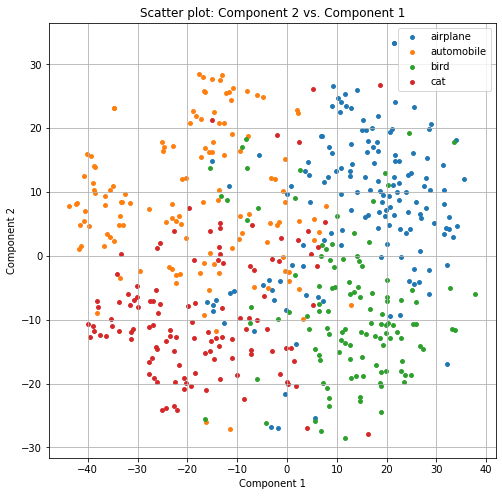

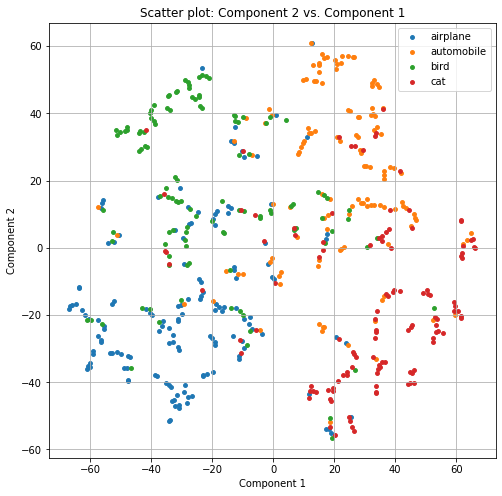

In [43]:
from sklearn.manifold import TSNE

for x, y in trainloader:
    features = convNetS(x.to(device)).view(opt.batch_size, -1)
    X_embedded = TSNE(n_components=2, perplexity=5).fit_transform(features.cpu().detach().numpy())
    make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)


    features = netS(x.to(device)).view(opt.batch_size, -1)
    X_embedded = TSNE(n_components=2, perplexity=5).fit_transform(features.cpu().detach().numpy() )
    make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)
    break